In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import os

%matplotlib inline

weather_file_path = '../raw_data/raw_weather_data.csv'
input_file_path = '../inputs/weather.csv'
figures_path = '../figures/'

ImportError: Unable to import required dependencies:
numpy: No module named 'unittest'

# This notebook generates weather data to use as input

Procedure is as follows:
- Read in weather data for a site in Northern California (3 years of data)
- Examine statistical properties of relevant weather variables
- Generate a longer time series with similar properties


Underlying assumptions ... 
- Time series observations are IID (obviously this is false)
- Weather variables are mutually uncorrelated (also false)

The reason I did this is that I wanted realistic weather values, and 3 years is much less than what grid operators would have available to them. My PG&E guy said he had 10 years, so I'm generating 10 years. Who knows how realistic that is. Maybe it should be 5, or 50, or 100, or all of the above. For now ... it's 10.

In [5]:
weatherData = pd.read_csv(weather_file_path, usecols=['temperature','precipIntensity','windSpeed'])

days = [weatherData.index[i:i+24] for i in range(len(weatherData.index)) if i % 24 == 0]

np.random.seed(seed=2)
bootstrap_days = np.random.choice(range(len(days)), replace=True, size=10*365)

bootstrap_index = []
for i in bootstrap_days:
    bootstrap_index.extend(days[i])

X = weatherData.loc[bootstrap_index].reset_index(drop=True).rename(columns={'temperature': 'Temp',
                                                           'precipIntensity': 'Precip',
                                                           'windSpeed': 'Wind'})

X['Wind'].loc[X['Wind']==0] = 1e-1

X = X.interpolate()

X['DayPrecip'] = X[['Precip']].rolling(24).sum()
X['DayPrecip'].loc[:24] = X['Precip'].loc[:24].sum()

X['HotCalm'] = X['Temp'] * (1./X['Wind'])
X['WindStorm'] = X['Wind'] * X['DayPrecip']

X.to_csv(input_file_path, index_label='time')

In [17]:
params = stats.lognorm.fit(weatherData['windSpeed'][pd.notnull(weatherData['windSpeed'])])

for t in range(15,100):
    print t, np.round(100*8760*(1-stats.lognorm.cdf(t, *params)),1), sum(X['Wind']>t)

15 27833.6 1485
16 20401.2 1014
17 14970.8 708
18 11004.0 509
19 8104.6 315
20 5982.9 221
21 4427.9 137
22 3285.8 90
23 2445.2 67
24 1824.9 53
25 1366.0 39
26 1025.6 25
27 772.3 17
28 583.3 17
29 441.9 12
30 335.8 12
31 255.9 9
32 195.6 9
33 149.9 9
34 115.3 9
35 88.9 9
36 68.7 6
37 53.2 6
38 41.4 3
39 32.3 0
40 25.2 0
41 19.7 0
42 15.5 0
43 12.2 0
44 9.6 0
45 7.6 0
46 6.0 0
47 4.8 0
48 3.8 0
49 3.0 0
50 2.4 0
51 2.0 0
52 1.6 0
53 1.3 0
54 1.0 0
55 0.8 0
56 0.7 0
57 0.5 0
58 0.4 0
59 0.4 0
60 0.3 0
61 0.2 0
62 0.2 0
63 0.2 0
64 0.1 0
65 0.1 0
66 0.1 0
67 0.1 0
68 0.1 0
69 0.0 0
70 0.0 0
71 0.0 0
72 0.0 0
73 0.0 0
74 0.0 0
75 0.0 0
76 0.0 0
77 0.0 0
78 0.0 0
79 0.0 0
80 0.0 0
81 0.0 0
82 0.0 0
83 0.0 0
84 0.0 0
85 0.0 0
86 0.0 0
87 0.0 0
88 0.0 0
89 0.0 0
90 0.0 0
91 0.0 0
92 0.0 0
93 0.0 0
94 0.0 0
95 0.0 0
96 0.0 0
97 0.0 0
98 0.0 0
99 0.0 0


In [5]:
idx = X
np.percentile(X['HotCalm'], 99)

100.96

In [6]:
H = np.histogram(X['Precip'], bins=np.arange(0,X['Precip'].max(),0.01))
series = pd.Series(H[0], H[1][:-1], H[0])
print series.sort_index(ascending=False)

0.22        1
0.21        6
0.20        0
0.19        2
0.18        0
0.17        2
0.16       13
0.15       12
0.14        3
0.13       14
0.12       10
0.11       24
0.10       21
0.09       56
0.08       47
0.07       43
0.06       57
0.05      120
0.04      207
0.03      245
0.02      373
0.01      680
0.00    85661
dtype: int64


In [6]:
weatherData = pd.read_csv(weather_file_path, usecols=['temperature','precipIntensity','windSpeed'])

idx = pd.notnull(weatherData['windSpeed'])
params = stats.lognorm.fit(weatherData['windSpeed'][idx])

X = pd.DataFrame(stats.lognorm.rvs(size=10*8760, *params), columns=['windSpeed'])


### Plot weather distribution

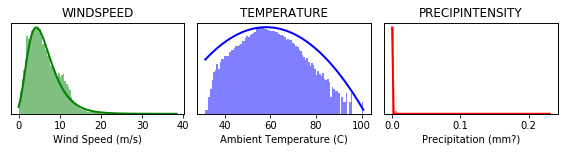

In [9]:
variables = {'windSpeed': stats.lognorm,
            'temperature': stats.norm,
            'precipIntensity': stats.lognorm,}

labels = {'windSpeed': 'Wind Speed (m/s)',
         'temperature': 'Ambient Temperature (C)',
         'precipIntensity': 'Precipitation (mm?)'}

distributions = {'windSpeed': 'Lognormal',
         'temperature': 'Normal',
         'precipIntensity': 'Exponential'}

colors = ['g','b','r']

param_approx = {}

fig, ax = plt.subplots(figsize=(8,2), ncols=3)

for i, var in enumerate(variables.keys()):    
    idx = pd.notnull(weatherData[var])  
    if i == 1:
        idx &= weatherData[var]>0#0.0010
    params = variables[var].fit(weatherData[var][idx])
    
    param_approx[var] = params
    
#     if i == 1:
#         bins=np.linspace(0,0.1,100)
#     else:
    bins=100

    ax[i].hist(weatherData[var][idx].tolist(), bins=bins, label='Observations', color=colors[i], alpha=0.5)
        
    ax2 = ax[i].twinx()
    xvals = np.linspace(weatherData[var].min(), weatherData[var].max(), 100)
    ax2.plot(xvals, variables[var].pdf(xvals, *params), color=colors[i], lw=2, label='%s Approx'%(distributions[var]))
    if i == 1:
        ax[i].set_yscale('log')
        ax2.set_yscale('log')
    else:
        ax2.set_ylim(0,ax2.get_ylim()[1])
    
    ax[i].set_title(var.upper())
    ax[i].set_yticks([])
    ax2.set_yticks([])
    ax[i].set_xlabel(labels[var])
                
fig.subplots_adjust(wspace=0.075, left=0.025, right=0.975, bottom=0.25)

plt.savefig(figure_path + 'ambient_conditions.png', dpi=100)

In [1]:
X = pd.DataFrame(columns=['Wind','Precip','Temp'],
                 index=range(10*8760))

X['Wind'] = np.round(stats.lognorm.rvs(*param_approx['windSpeed'], size=len(X)),2)
X['Temp'] = np.round(stats.norm.rvs(*param_approx['temperature'], size=len(X)),2)

X['Load-0.1'] = X['Temp'] + stats.norm.rvs(0, 0.1*np.mean(X['Temp']))
X['Load-0.2'] = X['Temp'] + stats.norm.rvs(0, 0.2*np.mean(X['Temp']))
X['Load-0.3'] = X['Temp'] + stats.norm.rvs(0, 0.3*np.mean(X['Temp']))


X['Precip'] = stats.bernoulli.rvs(sum(weatherData['precipIntensity']>0)/float(len(weatherData)), size=len(X))

idx = X['Precip'] == 1
X['Precip'].loc[idx] = np.round(stats.lognorm.rvs(*param_approx['precipIntensity'], size=sum(idx)),4)

X.to_csv(input_file_path, index_label='time')

NameError: name 'pd' is not defined